In [3]:
from tkinter import N
from joblib import PrintTime
import pvlib
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import daytime
import Funciones  
import seaborn as sns
from scipy import stats
from sklearn.metrics import mean_squared_error

# Ubicación 
Para el desarrollo del Proyecto fue necesario encontrar los datos metereológicos, para esto se utilizó la información de la base de datos del NSRDB. Esta es de uso libre pero se requiere una clave API que se obtiene al registrarse en la página de la NSRDB.

In [4]:
#Definir Zona Horaria
tz = 'America/Bogota'
lat, lon = 9.789103, -73.722451 #Estas son las coordenadas de el Paso
altitude=50

In [5]:
location = pvlib.location.Location(lat, lon, tz, altitude)

api_key = 'XXXXXXXXX'
email = 'XXXXXXXXXX'
elpaso_tmy, header = pvlib.iotools.get_psm3(lat, lon, api_key, email, 
                                            names='2020', interval=30)

In [6]:
tmy_columns_rename = ['Year', 'Month', 'Day', 'Hour', 'Minute', 'temp_air', 'Dew Point', 'dhi', 'dni', 'ghi', 'albedo', 'Pressure', 'Wind Direction', 'wind_speed']
elpaso_tmy.columns = tmy_columns_rename
elpaso_tmy.head()

,Year,Month,Day,Hour,Minute,temp_air,Dew Point,dhi,dni,ghi,albedo,Pressure,Wind Direction,wind_speed
2020-01-01 00:00:00-05:00,2020,1,1,0,0,26.2,22.3,0.0,0.0,0.0,0.18,998.0,64.0,0.1
2020-01-01 00:30:00-05:00,2020,1,1,0,30,26.0,22.3,0.0,0.0,0.0,0.18,998.0,64.0,0.1
2020-01-01 01:00:00-05:00,2020,1,1,1,0,25.7,22.1,0.0,0.0,0.0,0.18,997.0,65.0,0.0
2020-01-01 01:30:00-05:00,2020,1,1,1,30,25.6,22.1,0.0,0.0,0.0,0.18,997.0,106.0,0.0
2020-01-01 02:00:00-05:00,2020,1,1,2,0,25.5,21.5,0.0,0.0,0.0,0.18,997.0,147.0,0.0


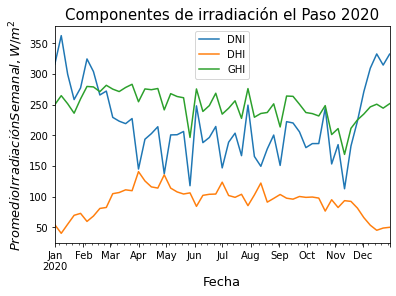

In [7]:
"Para"
elpaso_tmy.dni.resample("7D").mean().plot()
elpaso_tmy.dhi.resample("7D").mean().plot()
elpaso_tmy.ghi.resample("7D").mean().plot()
title='Componentes de irradiación el Paso 2020'
ylabel='$PromedioIrradiaciónSemanal, W/m^2$'
xlabel='Fecha'
plt.title(title, fontsize=15)
plt.ylabel(ylabel, fontsize=13)
plt.xlabel(xlabel, fontsize=13)
plt.legend(['DNI','DHI',"GHI"])

In [8]:
solpos = pvlib.solarposition.get_solarposition(elpaso_tmy.index, lat, lon)
# remove nighttime
elpaso_tmy = elpaso_tmy.loc[solpos['apparent_elevation'] > 0, :]
solpos = solpos.loc[solpos['apparent_elevation'] > 0, :]


# Sistema de seguimiento de 1 Eje
Para definir la posición del sistema de seguimiento se utiliza la función tracking.singleaxis esta permite definir la orientación, con el axis azimuth. Un axis azimuth de 180 define un sistema con seguimiento E-W

In [9]:
tracker = pvlib.tracking.singleaxis(apparent_zenith=solpos.apparent_zenith, 
                                    apparent_azimuth=solpos.azimuth, 
                                    axis_tilt=0,
                                    axis_azimuth=180, #Heading south
                                    max_angle=45, 
                                    backtrack=True, 
                                    gcr=0.25)

tracker = tracker.fillna(0)
tracker.head()


,tracker_theta,aoi,surface_azimuth,surface_tilt
2020-01-01 06:30:00-05:00,-11.974279,75.505824,90.0,11.974279
2020-01-01 07:00:00-05:00,-40.095083,45.067161,90.0,40.095083
2020-01-01 07:30:00-05:00,-45.000000,36.603523,90.0,45.000000
2020-01-01 08:00:00-05:00,-45.000000,32.933915,90.0,45.000000
2020-01-01 08:30:00-05:00,-45.000000,30.598709,90.0,45.000000


# Simulación irradiancia frontal Pérez
Para revizar los resultados de la Radiación frontal se realizó una simulación utilizando el modelo de Pérez. Para esto se utilizó el siguiente código.

In [10]:
airmass = location.get_airmass(times=elpaso_tmy.index, 
                               solar_position=solpos, 
                               model='kastenyoung1989')

airmass.head()
etr_nrel = pvlib.irradiance.get_extra_radiation(datetime_or_doy=elpaso_tmy.index, 
                                          method='NREL', 
                                          solar_constant=1361);
surface_albedo = pvlib.irradiance.SURFACE_ALBEDOS['soil']; # Check the surfaces albedo list with print(irradiance.SURFACE_ALBEDOS.items()) function
solpos.to_csv(path_or_buf='path2')

poa_perez = pvlib.irradiance.get_total_irradiance(surface_tilt=tracker.surface_tilt, 
                                            surface_azimuth=tracker.surface_azimuth, 
                                            solar_zenith=solpos.apparent_zenith, 
                                            solar_azimuth=solpos.azimuth, 
                                            dni=elpaso_tmy.dni, 
                                            ghi=elpaso_tmy.ghi, 
                                            dhi=elpaso_tmy.dhi, 
                                            dni_extra=etr_nrel, 
                                            airmass=airmass.airmass_relative, 
                                            albedo=surface_albedo, 
                                            surface_type='soil', 
                                            model='perez', 
                                            model_perez='allsitescomposite1990')

# PVfactors
Para Aplicar el modelo de PV factors se utilizó la incorporación de pvfactor en pvlib. Esta función aplica el método rápido del programa pvfactors.

In [11]:
"""
$Parámetros
gcr= ground coverage ratio
pvrow_height= altura del punto medio del panel
pvrow_width= ancho de panel
albedo= reflectividad del suelo entre 0 y 1
n_pvrows=número de filas a simular
index_observed_pvrow= índice de fila a evaluar entre 0 y n_pvrows-1
rho_back_pvrow= reflectividad del panel cara trasera,
rho_front_pvrow= reflectividad del panel cara frontal,

$Resultados
poa_front= Irradiancia frontal 
poa_back= Irradiancia trasera 
poa_frontabsorb=Irradiancia frontal después de perdidas por AOI
poa_backabsorb= Irradiancia trasera después de perdidas por AOI
"""

poa_front,poa_back,poa_frontabsorb,poa_backabsorb = pvlib.bifacial.pvfactors_timeseries(surface_tilt=tracker.surface_tilt, 
                                                                        surface_azimuth=tracker.surface_azimuth, 
                                                                        solar_zenith=solpos.zenith, 
                                                                        solar_azimuth=solpos.azimuth, 
                                                                        axis_azimuth=180,
                                                                        timestamps=elpaso_tmy.index,
                                                                        dni=elpaso_tmy.dni, 
                                                                        dhi=elpaso_tmy.dhi,
                                                                        gcr=0.25,
                                                                        pvrow_height=1,
                                                                        pvrow_width=0.98,
                                                                        #albedo=surface_albedo,
                                                                        albedo=0.5, 
                                                                        n_pvrows=5,
                                                                        index_observed_pvrow=2,
                                                                        rho_back_pvrow=0.05,
                                                                        rho_front_pvrow=0.03,
                                                                        horizon_band_angle=15)

c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\geometry\base.py:349: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  self.list_surfaces = list_surfaces
c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\geometry\base.py:350: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  self.shaded = self._get_shading(shaded)
c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\geometry\base.py:351: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  self.is_collinear = is_collinear(list_surfaces)
c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\geometry\base.py:352: ShapelyDeprecationWarning: Setting custom a

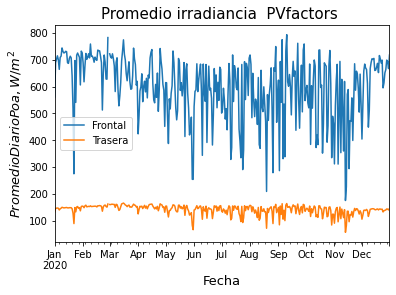

In [12]:
"Gráfica de promedio diario de irraciancía trasera y frontal"
#poa_frontabsorb.plot()
poa_frontabsorb_mean=poa_frontabsorb.resample("1D").mean()
poa_frontabsorb_mean.plot()
poa_backabsorb_mean=poa_backabsorb.resample("1D").mean()
poa_backabsorb_mean.plot()
title='Promedio irradiancia  PVfactors '
ylabel='$Promedio Diario Poa, W/m^2$'
xlabel='Fecha'
plt.title(title, fontsize=15)
plt.ylabel(ylabel, fontsize=13)
plt.xlabel(xlabel, fontsize=13)
plt.legend(['Frontal','Trasera'])


# Comparación efecto de la posición en el array

Para evaluar el efecto de borde se evaluó el efecto del parámetro index_observed_pvrow 

In [13]:
poa_front3,poa_back3,poa_frontabsorb3,poa_backabsorb3 = pvlib.bifacial.pvfactors_timeseries(surface_tilt=tracker.surface_tilt, 
                                                                        surface_azimuth=tracker.surface_azimuth, 
                                                                        solar_zenith=solpos.zenith, 
                                                                        solar_azimuth=solpos.azimuth, 
                                                                        axis_azimuth=0,
                                                                        timestamps=elpaso_tmy.index,
                                                                        dni=elpaso_tmy.dni, 
                                                                        dhi=elpaso_tmy.dhi,
                                                                        gcr=0.25,
                                                                        pvrow_height=1,
                                                                        pvrow_width=0.98,
                                                                        #albedo=surface_albedo,
                                                                        albedo=0.5, 
                                                                        n_pvrows=5,
                                                                        index_observed_pvrow=2,
                                                                        rho_back_pvrow=0.05,
                                                                        rho_front_pvrow=0.03,
                                                                        horizon_band_angle=15)

c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\viewfactors\vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)
c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\viewfactors\vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)
c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\viewfactors\vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)
c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\viewfactors\vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)
c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\v

In [14]:

poa_front1,poa_back1,poa_frontabsorb1,poa_backabsorb1 = pvlib.bifacial.pvfactors_timeseries(surface_tilt=tracker.surface_tilt, 
                                                                        surface_azimuth=tracker.surface_azimuth, 
                                                                        solar_zenith=solpos.zenith, 
                                                                        solar_azimuth=solpos.azimuth, 
                                                                        axis_azimuth=0,
                                                                        timestamps=elpaso_tmy.index,
                                                                        dni=elpaso_tmy.dni, 
                                                                        dhi=elpaso_tmy.dhi,
                                                                        gcr=0.25,
                                                                        pvrow_height=1,
                                                                        pvrow_width=0.98,
                                                                        #albedo=surface_albedo,
                                                                        albedo=0.5, 
                                                                        n_pvrows=5,
                                                                        index_observed_pvrow=0,
                                                                        rho_back_pvrow=0.05,
                                                                        rho_front_pvrow=0.03,
                                                                        horizon_band_angle=15)

c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\viewfactors\vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)
c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\viewfactors\vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)
c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\viewfactors\vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)
c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\viewfactors\vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)
c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\v

In [15]:
poa_front5,poa_back5,poa_frontabsorb5,poa_backabsorb5 = pvlib.bifacial.pvfactors_timeseries(surface_tilt=tracker.surface_tilt, 
                                                                        surface_azimuth=tracker.surface_azimuth, 
                                                                        solar_zenith=solpos.zenith, 
                                                                        solar_azimuth=solpos.azimuth, 
                                                                        axis_azimuth=0,
                                                                        timestamps=elpaso_tmy.index,
                                                                        dni=elpaso_tmy.dni, 
                                                                        dhi=elpaso_tmy.dhi,
                                                                        gcr=0.25,
                                                                        pvrow_height=1,
                                                                        pvrow_width=0.98,
                                                                        #albedo=surface_albedo,
                                                                        albedo=0.5, 
                                                                        n_pvrows=5,
                                                                        index_observed_pvrow=4,
                                                                        rho_back_pvrow=0.05,
                                                                        rho_front_pvrow=0.03,
                                                                        horizon_band_angle=15)

c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\viewfactors\vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)
c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\viewfactors\vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)
c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\viewfactors\vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)
c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\viewfactors\vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)
c:\Users\dalpt\AppData\Local\Programs\Python\Python310\lib\site-packages\pvfactors\v

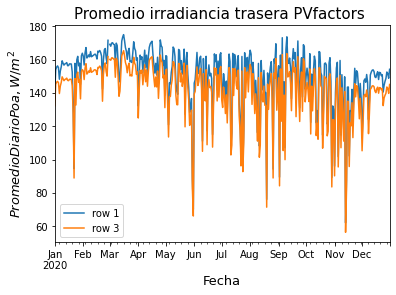

In [16]:
poa_back_mean1=poa_backabsorb1.resample("1D").mean()
poa_back_mean1.plot()
poa_back_mean3=poa_backabsorb3.resample("1D").mean()
poa_back_mean3.plot()
poa_back_mean5=poa_backabsorb5.resample("1D").mean()
#poa_back_mean5.plot()
title='Promedio irradiancia trasera PVfactors '
ylabel='$Promedio Diario Poa, W/m^2$'
xlabel='Fecha'
plt.title(title, fontname="Helvetica", fontsize=15)
plt.ylabel(ylabel, fontname="Helvetica", fontsize=13)
plt.xlabel(xlabel, fontname="Helvetica", fontsize=13)
plt.legend(['row 1','row 3'])

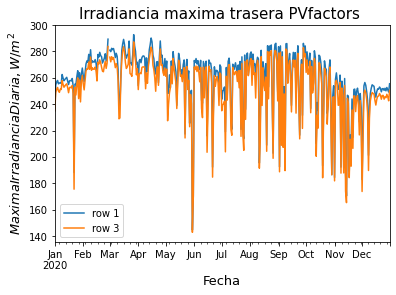

In [17]:
poa_back_max1=poa_backabsorb1.resample("1D").max()
poa_back_max1.plot()
poa_back_max3=poa_backabsorb3.resample("1D").max()
poa_back_max3.plot()
poa_back_max5=poa_backabsorb5.resample("1D").max()
#poa_back_max5.plot()
title='Irradiancia maxima trasera PVfactors '
ylabel='$Maxima Irradiancia Diaria, W/m^2$'
xlabel='Fecha'
plt.title(title, fontname="Helvetica", fontsize=15)
plt.ylabel(ylabel, fontname="Helvetica", fontsize=13)
plt.xlabel(xlabel, fontname="Helvetica", fontsize=13)
plt.legend(['row 1','row 3'])

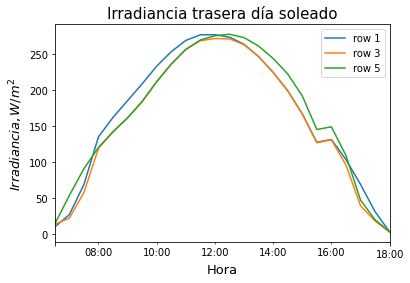

In [18]:
fecha = '2020-02-20 '
poa_1=poa_backabsorb1[fecha+'00:00:00':fecha+'23:59:00']
poa_2=poa_backabsorb3[fecha+'00:00:00':fecha+'23:59:00']
poa_3=poa_backabsorb5[fecha+'00:00:00':fecha+'23:59:00']
poa_1.plot()
poa_2.plot()
poa_3.plot()
title='Irradiancia trasera día soleado'
ylabel='$Irradiancia, W/m^2$'
xlabel='Hora'
plt.title(title, fontname="Helvetica", fontsize=15)
plt.ylabel(ylabel, fontname="Helvetica", fontsize=13)
plt.xlabel(xlabel, fontname="Helvetica", fontsize=13)
plt.legend(['row 1','row 3','row 5'])

# Comparación poa_frontabsorb, poa_front y poa_perez

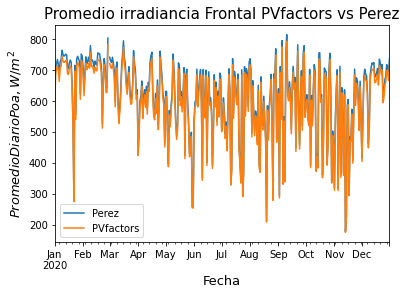

In [19]:
#poa_perez.poa_global.plot()

poa_perez_mean=poa_perez.poa_global.resample("1D").mean()
poa_perez_mean.plot()
poa_frontabsorb_mean.plot()
title='Promedio irradiancia Frontal PVfactors vs Perez'
ylabel='$Promedio Diario Poa, W/m^2$'
xlabel='Fecha'
plt.title(title, fontname="Helvetica", fontsize=15)
plt.ylabel(ylabel, fontname="Helvetica", fontsize=13)
plt.xlabel(xlabel, fontname="Helvetica", fontsize=13)
plt.legend(['Perez','PVfactors'])

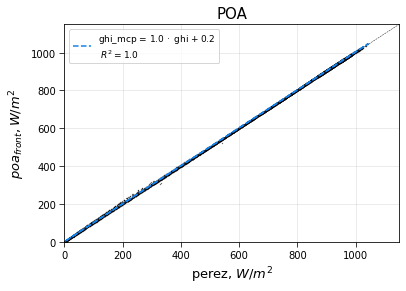

R2:  1.0
RMSE:  0.38
MAPE:  0.35


In [20]:
irrads = pd.DataFrame({'perez': poa_perez['poa_global'], 
                           'poa_front': poa_front})

irrads = irrads.dropna()
#Least Squares Linear Regression
x_value = irrads.perez
y_value = irrads.poa_front

coef = np.polyfit(x_value, y_value, 1)
poly1d_fn = np.poly1d(coef)

slope, intercept, r_value, p_value, std_err = stats.linregress(x_value, 
                                                                  y_value)

#Figure
axis_lim = 1150

x = np.linspace(0, axis_lim, axis_lim)
y_reg = slope*x + intercept
                        
plt.figure()
plt.plot(x_value, 
            poly1d_fn(x_value), 
            '--',
            label=('ghi_mcp = ' + 
                  f'{slope.round(2)} $· \:$ ghi $+ \:$' + 
                  f'{intercept.round(2)} \n $R^2 = $' 
                  + f'{r_value.round(4)}'), 
            color='#1580E4', linewidth=1.5, zorder = 10)

plt.plot(x_value, y_value, color='black', ls='', 
            marker='.', ms=0.5, fillstyle='none')

y = x
plt.plot(x, y, '--', color='#222020', linewidth=0.5)

Funciones.plot_specs(title=f'POA',
            ylabel='$poa_{front}, W/m^2$',
            xlabel='perez, $W/m^2$',
            rot=0, 
            ylim_min=0, ylim_max=axis_lim, 
            xlim_min=0, xlim_max=axis_lim, 
            loc='best')
                        
plt.show()
                        
#METRICS
Funciones.metrics(r2=r_value, measured=x_value, modeled=y_value, store=False)

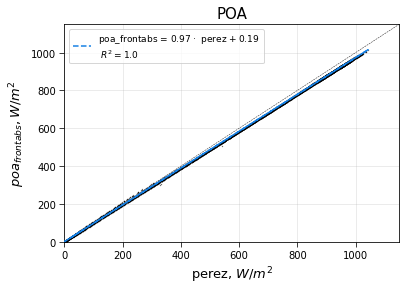

R2:  1.0
RMSE:  1.78
MAPE:  2.83


In [21]:
irrads = pd.DataFrame({'perez': poa_perez['poa_global'], 
                           'poa_frontabsorb': poa_frontabsorb})

irrads = irrads.dropna()
#Least Squares Linear Regression
x_value = irrads.perez
y_value = irrads.poa_frontabsorb

coef = np.polyfit(x_value, y_value, 1)
poly1d_fn = np.poly1d(coef)

slope, intercept, r_value, p_value, std_err = stats.linregress(x_value, 
                                                                  y_value)

#Figure
axis_lim = 1150

x = np.linspace(0, axis_lim, axis_lim)
y_reg = slope*x + intercept
                        
plt.figure()
plt.plot(x_value, 
            poly1d_fn(x_value), 
            '--',
            label=('poa_frontabs = ' + 
                  f'{slope.round(2)} $· \:$ perez $+ \:$' + 
                  f'{intercept.round(2)} \n $R^2 = $' 
                  + f'{r_value.round(4)}'), 
            color='#1580E4', linewidth=1.5, zorder = 10)

plt.plot(x_value, y_value, color='black', ls='', 
            marker='.', ms=0.5, fillstyle='none')

y = x
plt.plot(x, y, '--', color='#222020', linewidth=0.5)

Funciones.plot_specs(title=f'POA',
            ylabel='$poa_{frontabs}, W/m^2$',
            xlabel='perez, $W/m^2$',
            rot=0, 
            ylim_min=0, ylim_max=axis_lim, 
            xlim_min=0, xlim_max=axis_lim, 
            loc='best')
                        
                        
plt.show()
                        
#METRICS
Funciones.metrics(r2=r_value, measured=x_value, modeled=y_value, store=False)

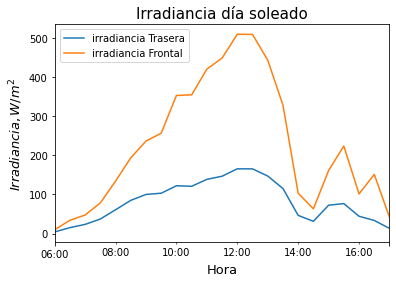

In [22]:
fecha = '2020-11-14 '
poa_1=poa_backabsorb[fecha+'00:00:00':fecha+'23:59:00']
poa_2=poa_frontabsorb[fecha+'00:00:00':fecha+'23:59:00']

poa_1.plot()
poa_2.plot()
title='Irradiancia día soleado'
ylabel='$Irradiancia, W/m^2$'
xlabel='Hora'
plt.title(title, fontname="Helvetica", fontsize=15)
plt.ylabel(ylabel, fontname="Helvetica", fontsize=13)
plt.xlabel(xlabel, fontname="Helvetica", fontsize=13)
plt.legend(['irradiancia Trasera','irradiancia Frontal'])

Text(0.5, 0, 'Fecha')

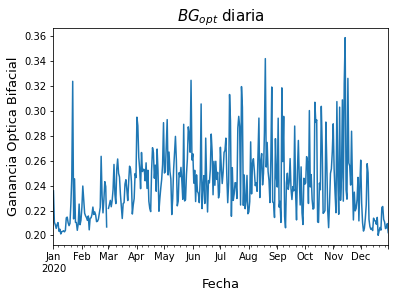

In [23]:
fecha = '2020-11-28 '
fecha2='2020-11-29 '
poa_1=poa_backabsorb
poa_2=poa_frontabsorb
poa_backabsorb_sum=poa_backabsorb.resample("1D").sum()
poa_frontabsorb_sum=poa_frontabsorb.resample("1D").sum()
bg_opt=poa_backabsorb_sum.truediv(poa_frontabsorb_sum)

#bg_opt=bg_opt.resample("7D").mean()

bg_opt.plot()
title='$BG_{opt}$ diaria'
ylabel='Ganancia Optica Bifacial'
xlabel='Fecha'
plt.title(title, fontname="Helvetica", fontsize=15)
plt.ylabel(ylabel, fontname="Helvetica", fontsize=13)
plt.xlabel(xlabel, fontname="Helvetica", fontsize=13)



# Calculo de la producción energetica total

In [24]:
def irrad_total_bifacial(front,back, bifaciality):
    "Función para encontrar la radiación efectiva en base a la bifacilidad de la celda y la irradiancia frontal y trasera"
    try:
        x=back.mul(bifaciality)
        irrad=front.add(x)
        return(irrad)
    except: 
        print("irrad_total_bifacial failed")

In [25]:
irrad3=irrad_total_bifacial(poa_frontabsorb,
                            poa_backabsorb,0.90)

irrad1=irrad_total_bifacial(poa_frontabsorb1,
                            poa_backabsorb1,0.90)

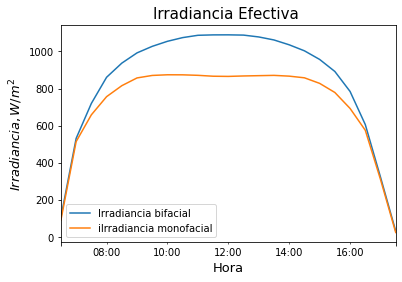

In [26]:
fecha= '2020-12-20 '    #Fecha bajo BG
#fecha = '2020-08-19 ' #Fecha alto BG
poa_1=irrad3[fecha+'00:00:00':fecha+'23:59:00']
poa_2=poa_frontabsorb[fecha+'00:00:00':fecha+'23:59:00']

poa_1.plot()
poa_2.plot()
title='Irradiancia Efectiva '
ylabel='$Irradiancia, W/m^2$'
xlabel='Hora'
plt.title(title, fontname="Helvetica", fontsize=15)
plt.ylabel(ylabel, fontname="Helvetica", fontsize=13)
plt.xlabel(xlabel, fontname="Helvetica", fontsize=13)
plt.legend(['Irradiancia bifacial','iIrradiancia monofacial'])

Para encontrar la temperatura de la celda se utilizó el modelo sandia con los parametros a y b para un modulo de estructura a vidrio/celda/vidrio

In [27]:
temp_cell = pvlib.temperature.sapm_module(poa_global=poa_front, 
                                        temp_air=elpaso_tmy.temp_air, 
                                        wind_speed=elpaso_tmy.wind_speed, 
                                        a=-3.47, 
                                        b=-0.0594)


In [28]:
modules_database = 'CECMOD'
modules = pvlib.pvsystem.retrieve_sam(modules_database)

modules.to_csv("DB.csv")
module=modules.LG_Electronics_Inc__LG370N2T_A4
print(module)

Technology            Mono-c-Si
Bifacial                      1
STC                      370.76
PTC                       340.6
A_c                        1.95
Length                     1.99
Width                      0.98
N_s                          72
I_sc_ref                   9.78
V_oc_ref                   48.8
I_mp_ref                    9.2
V_mp_ref                   40.3
alpha_sc               0.002934
beta_oc                -0.13176
T_NOCT                     46.8
a_ref                  1.829992
I_L_ref                9.790371
I_o_ref                     0.0
R_s                    0.311815
R_sh_ref             294.038879
Adjust                 8.790824
gamma_r                   -0.37
BIPV                          N
Version       SAM 2018.11.11 r2
Date                   1/3/2019
Name: LG_Electronics_Inc__LG370N2T_A4, dtype: object


In [29]:
inverters_database = 'CECInverter'
inverters = pvlib.pvsystem.retrieve_sam(inverters_database)
inversor = inverters.Power_Electronics__FS1275CU15__690V_
print(inversor)

Vac                          690
Pso                 12941.101563
Paco                   1389080.0
Pdco                   1421523.0
Vdco                      1030.0
C0                          -0.0
C1                      0.000007
C2                     -0.000112
C3                      0.000557
Pnt                      416.724
Vdcmax                    1200.0
Idcmax               1380.119417
Mppt_low                   976.0
Mppt_high                 1200.0
CEC_Date              10/15/2018
CEC_Type     Utility Interactive
Name: Power_Electronics__FS1275CU15__690V_, dtype: object


Para que el sistema tenga la relación DC/AC de 1.36 se definió el siguiente sistema

In [30]:
mps = 25 #Modules Per String
spi = 210 #Strings Per Inverter


system = pvlib.pvsystem.PVSystem(module_parameters=module, 
                    inverter_parameters=inversor, 
                    modules_per_string=mps, 
                    strings_per_inverter=spi)


In [31]:
def dc_production(effective_irradiance, module_temperature,module,system):
    """Función para el cálculo de la produción DC"""

    
    #Single Diode Parameters
    IL, I0, Rs, Rsh, nNsVth = pvlib.pvsystem.calcparams_cec(effective_irradiance,
                                                      module_temperature,
                                                      module['alpha_sc'],
                                                      module['a_ref'],
                                                      module['I_L_ref'],
                                                      module['I_o_ref'],
                                                      module['R_sh_ref'],
                                                      module['R_s'],
                                                      module['Adjust'],
                                                      EgRef=1.121,
                                                      dEgdT=-0.0002677)

    curve_info = pvlib.pvsystem.singlediode(photocurrent=IL,
                                      saturation_current=I0,
                                      resistance_series=Rs,
                                      resistance_shunt=Rsh,
                                      nNsVth=nNsVth,
                                      ivcurve_pnts=100,
                                      method='lambertw')

    #Scalating CEC et. al. Single Diode Results
    data_i_sc = pd.Series(curve_info['i_sc'])
    data_v_oc = pd.Series(curve_info['v_oc'])
    data_i_mp = pd.Series(curve_info['i_mp'])
    data_v_mp = pd.Series(curve_info['v_mp'])
    data_p_mp = pd.Series(curve_info['p_mp'])
    data_i_x = pd.Series(curve_info['i_x'])
    data_i_xx = pd.Series(curve_info['i_xx'])

    results_general = pd.DataFrame({'i_sc': data_i_sc, 
                                    'v_oc': data_v_oc,
                                    'i_mp': data_i_mp, 
                                    'v_mp': data_v_mp, 
                                    'p_mp': data_p_mp, 
                                    'i_x': data_i_x,
                                    'i_xx': data_i_xx})

    #DC Dataframe
    datetime_index = effective_irradiance.index

    dc = system.scale_voltage_current_power(results_general)
    dc = dc.set_index(datetime_index)

    
    return dc

In [32]:
Dc_bi_mid=dc_production(irrad3,temp_cell,module,system)
Dc=dc_production(poa_frontabsorb,temp_cell,module,system)

# Pérdidas
El cálculo de pérdidas se aplica sobre la potencia DC, las perdidas se calcularon de acuerdo a lo reportado por NREL para los sistemas bifaciales.

In [33]:
def losses(dc, loss):
    losses = loss/100 
    dcl=dc.copy()
    dcl['i_mp'] = dc['i_mp'] - dc['i_mp']*losses
    dcl['p_mp'] = dc['p_mp'] - dc['p_mp']*losses
    return dc

In [34]:

Dc_bi_mid_l=losses(Dc_bi_mid, 16.5)
Dc_l=losses(Dc, 16.5)

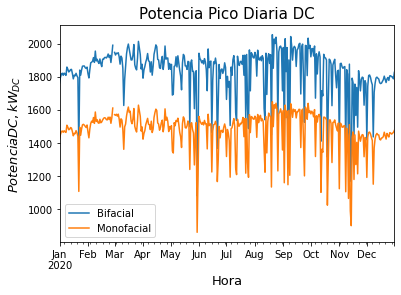

In [35]:
fecha = '2020-07-10 '
Dc_1=Dc_bi_mid_l.resample("1D").max()#[fecha+'00:00:00':fecha+'23:59:00']
Dc_2=Dc_l.resample("1D").max()#[fecha+'00:00:00':fecha+'23:59:00']
Dc_1=Dc_1["p_mp"]/1000
Dc_2=Dc_2["p_mp"]/1000
Dc_1.plot()
Dc_2.plot()
title='Potencia Pico Diaria DC'
ylabel='$Potencia DC, kW_{DC}$'
xlabel='Hora'
plt.title(title, fontsize=15)
plt.ylabel(ylabel, fontsize=13)
plt.xlabel(xlabel, fontsize=13)
plt.legend(["Bifacial","Monofacial"])


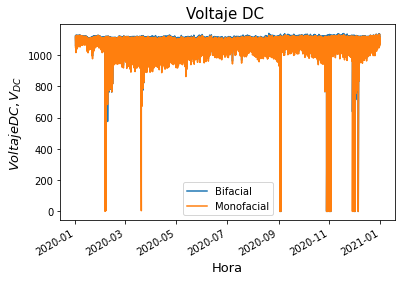

In [36]:
" Gráfica máximo voltaje VOC "
"Se verificó que el voltaje máximo fuera menor al voltaje máximo del inversor"

Voc_bi=Dc_bi_mid_l["v_oc"]
Voc_bi.plot()
Voc=Dc_l["v_oc"]
Voc.plot()
title='Voltaje DC '
ylabel='$Voltaje DC, V_{DC}$'
xlabel='Hora'
plt.title(title, fontsize=15)
plt.ylabel(ylabel, fontsize=13)
plt.xlabel(xlabel, fontsize=13)
plt.legend(["Bifacial","Monofacial"])


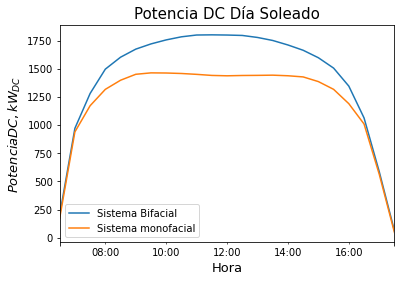

In [37]:
fechag= '2020-12-20 '    #Fecha bajo BG
#fechag = '2020-08-19 ' #Fecha alto BG

Dcg_1=Dc_bi_mid_l["p_mp"]
Dcg_2=Dc_l["p_mp"]
Dcg_1=Dcg_1[fechag+'00:00:00':fechag+'23:59:00']

Dcg_2=Dcg_2[fechag+'00:00:00':fechag+'23:59:00']
Dcg_1=Dcg_1/1000
Dcg_2=Dcg_2/1000
Dcg_1.plot()
Dcg_2.plot()

title='Potencia DC Día Soleado'
ylabel='$Potencia DC, kW_{DC}$'
xlabel='Hora'
plt.title(title, fontsize=15)
plt.ylabel(ylabel, fontsize=13)
plt.xlabel(xlabel, fontsize=13)
plt.legend(["Sistema Bifacial","Sistema monofacial"])

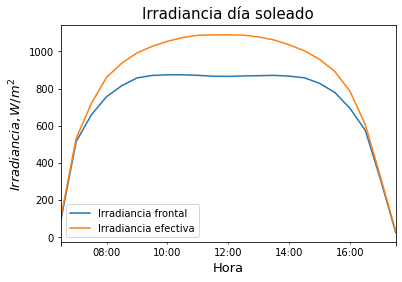

In [38]:

poa_3=poa_frontabsorb[fechag+'00:00:00':fechag+'23:59:00']
irrad_3=irrad3[fechag+'00:00:00':fechag+'23:59:00']

poa_3.plot()
irrad_3.plot()
title='Irradiancia día soleado'
ylabel='$Irradiancia, W/m^2$'
xlabel='Hora'
plt.title(title, fontsize=15)
plt.ylabel(ylabel, fontsize=13)
plt.xlabel(xlabel, fontsize=13)
plt.legend(["Irradiancia frontal","Irradiancia efectiva"])


Cálculo de producción ac

In [39]:
#PVlib (SAPM) AC Model
def pvlib_ac_power(dc,inverter, total_inversores=1):
    "Calcula la producción ac del sistema en base a los datos del sistema dc y "
    ac= pvlib.inverter.sandia(dc['v_mp'], dc['p_mp'], inverter)
    
    
    pvlib_ac = ac * total_inversores
    
    pvlib_ac.loc[pvlib_ac < 0] = 0
    pvlib_ac.fillna(value=0, inplace=True)
    
    return pvlib_ac


In [40]:
ac_bi=pvlib_ac_power(Dc_bi_mid_l,inversor)
ac=pvlib_ac_power(Dc_l,inversor)


0.024324997439479024


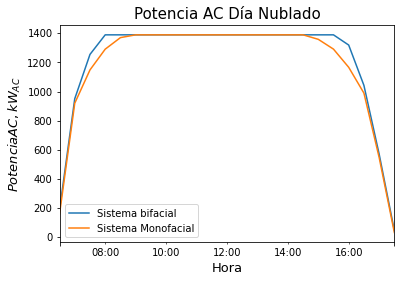

In [41]:



ac_1=ac_bi[fechag+'00:00:00':fechag+'23:59:00']
ac_2=ac[fechag+'00:00:00':fechag+'23:59:00']
ac_1=ac_1/1000
ac_2=ac_2/1000
ac_1.plot()
ac_2.plot()
ac_1sum=ac_1.sum()
ac_2sum=ac_2.sum()
BG_0=ac_1sum/ac_2sum-1
print(BG_0)
title='Potencia AC Día Nublado'
ylabel='$Potencia AC, kW_{AC}$'
xlabel='Hora'
plt.title(title, fontsize=15)
plt.ylabel(ylabel, fontsize=13)
plt.xlabel(xlabel, fontsize=13)
plt.legend(["Sistema bifacial","Sistema Monofacial"])

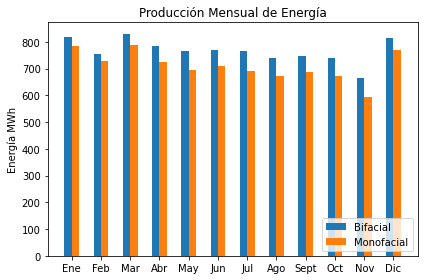

In [42]:
"Grafica producción ac Mensual"

ac_bi_daily=ac_bi.resample("1M").sum()
ac_daily=ac.resample("1M").sum()
ac_BG=(ac_bi_daily/ac_daily-1)*100
labels=["Ene","Feb","Mar","Abr","May","Jun","Jul","Ago","Sept","Oct","Nov","Dic"]

fig, ax = plt.subplots()
x=np.arange(12)
width=0.25
rects1 = ax.bar(x - width/2, ac_bi_daily/1000000, width, label='Bifacial')
rects2 = ax.bar(x + width/2, ac_daily/1000000, width, label='Monofacial')

ax.set_ylabel('Energía MWh')
ax.set_title('Producción Mensual de Energía')
ax.set_xticks(x, labels)
ax.legend(["Bifacial","Monofacial"],loc="lower right")


fig.tight_layout()

plt.show()



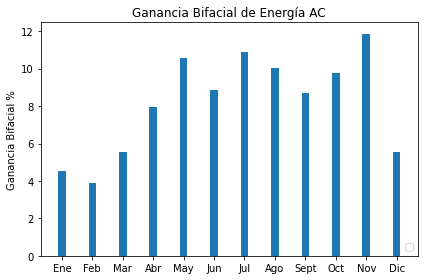

In [43]:
"Grafica Ganancia bifacial energía AC"
fig, ax = plt.subplots()
x=np.arange(12)
width=0.25
rects1 = ax.bar(x , ac_BG, width, )

ax.set_ylabel('Ganancia Bifacial %')
ax.set_title('Ganancia Bifacial de Energía AC')
ax.set_xticks(x, labels)
ax.legend(loc="lower right")


fig.tight_layout()

plt.show()

In [44]:
Energy_bi=ac_bi.sum()
print(Energy_bi)
Energy=ac.sum()
print(Energy)
EnergyBG=(Energy_bi/Energy-1)*100
print(EnergyBG)

9199225785.098757
8516153138.220816
8.02090610386379


In [45]:
Dc=Dc_bi_mid_l["p_mp"].sum()
Dc_mono=Dc_l["p_mp"].sum()
print(Dc)
print(Dc_mono)
bgdc=(Dc/Dc_mono-1)*100
print(bgdc)

10816383562.575417
8941475290.68057
20.968668043505147
